<a href="https://colab.research.google.com/github/Surihub/Recommender-system/blob/main/TIMSS_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TIMSS recommender system
- 알고리즘 설정 : 두 가지만
- 함수 설정
- 정오답 예측 결과
- 추천 결과
- 추천의 정확도 결과

## 데이터 불러오기

In [28]:
import time
import math 
import random 
import datetime 
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from google.colab import drive

# 데이터 불러오기
drive.mount("/content/gdrive/")
path = "/content/gdrive/MyDrive/2023석사논문코드/"
#path = "/content/gdrive/MyDrive/"
iteminfo = pd.read_csv(path+"iteminfo_ME10_ME11.csv")
timss19 = pd.read_csv(path+"df_RFS_ME10_ME11.csv", index_col=0).drop(labels = ['IDCNTRY',"IDSTUD"], axis = 1)
display(iteminfo.head(3))
print(iteminfo.shape)
display(timss19.head(3))
print(timss19.shape)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


,Unnamed: 0,Block,Block_seq,Content_Domain,Topic_Area,Cognitive_Domain,Item_Type,Label,correct_per1,correct_per2,Item_ID
0,ME72187,ME10,1,Number,Integers,Knowing,CR,Sum of two numbers with exponents,0.556271,0.566869,ME72187
1,ME62271,ME11,1,Number,Fractions and Decimals,Knowing,MC,Randy's blue balloons,0.504519,0.510844,ME62271
2,ME72022,ME10,2,Number,Fractions and Decimals,Reasoning,MC,Value of P x Q on number line,0.395196,0.402929,ME72022


(28, 11)


,ME72187,ME72022,ME72045,ME72049,ME72069,ME72074,ME72013,ME72095,ME72109,ME72125,...,ME62230_F,ME62095_F,ME62076_F,ME62030_F,ME62171_F,ME62301_F,ME62194_F,ME62344_F,ME62320_F,ME62296_F
784_50010216,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,2.0,2.0,3.0,3.0,2.0,3.0,6.0,3.0,3.0,2.0
784_50010314,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,2.0
784_50030104,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0


(8077, 84)


In [29]:
## input data : timss19(pd.DataFrame 형태)
Utility_mat_total = timss19

# n_item : 문항정보표에서 가져오기
n_item = len(iteminfo)

# item_list : ME00000, 문항
item_list = Utility_mat_total.columns[n_item * 0 :n_item * 1] # 전체 아이템 리스트

# time_list : ME00000_S, 문항에 소요된 시간
time_list = Utility_mat_total.columns[n_item * 1 :n_item * 2] # 아이템_S

# freq_list : ME00000_F, 문항 클릭 빈도수
freq_list = Utility_mat_total.columns[n_item * 2 :n_item * 3] # 아이템_F

# response only
U_R = Utility_mat_total[item_list]+1

# sptime only
U_S = Utility_mat_total[time_list]

# frequency only
U_F = Utility_mat_total[freq_list]

# user item matrix를 row matrix로 변환(역 pivot) 함수
def ui_to_row(df):
  temp = df.copy()
  temp["IDSTUD"] = temp.index
  df_row = pd.melt(temp, id_vars = "IDSTUD", var_name = 'Item_ID', value_name = 'value')
  # na 제거
  df_row = df_row.dropna()
  df_row['Item_ID'] = df_row['Item_ID'].apply(lambda x: x[:7])
  return df_row

# display(ui_to_row(U_R).head(3))
# display(ui_to_row(U_S).head(3))
# display(ui_to_row(U_F).head(3))

## 예측 및 예측 결과 정리

In [30]:
!pip install scikit-surprise
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise import Dataset, BaselineOnly, Reader, accuracy
from surprise.model_selection import cross_validate, train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np

def cosine_similarity(X):
    """
    코사인 유사도 계산 함수
    X: array-like, shape (n_samples, n_features)
    """
    return 1 - pairwise_distances(X, metric='cosine')

def msd_similarity(X):
    """
    MSD 유사도 계산 함수
    X: array-like, shape (n_samples, n_features)
    """
    return 1 / (1 + pairwise_distances(X, metric='sqeuclidean'))

def pearson_similarity(X):
    """
    피어슨 유사도 계산 함수
    X: array-like, shape (n_samples, n_features)
    """
    X = np.asarray(X)
    X = X - np.mean(X, axis=0)
    return 1 - pairwise_distances(X, metric='correlation')

def similarity(X):
  print(X)
  print('코사인유사도:\t',cosine_similarity(X)[0,1]) #scale에 영향을 받음
  print('MSD유사도:\t',msd_similarity(X)[0,1]) #scale에 영향을 받지 않음
  print('피어슨유사도:\t',pearson_similarity(X)[0,1])
  print('\n')

similarity(np.array(U_R.iloc[:2,:10]))
similarity(np.array(U_R.iloc[:2,:10]-1))
similarity(np.array(U_R.iloc[1011:1013,:10]))
similarity(np.array(U_R.iloc[1011:1013,:10]-1))

[[2. 1. 2. 2. 2. 2. 2. 2. 1. 2.]
 [1. 2. 1. 2. 1. 1. 2. 1. 1. 1.]]
코사인유사도:	 0.9049228966693288
MSD유사도:	 0.125
피어슨유사도:	 -1.0


[[1. 0. 1. 1. 1. 1. 1. 1. 0. 1.]
 [0. 1. 0. 1. 0. 0. 1. 0. 0. 0.]]
코사인유사도:	 0.408248290463863
MSD유사도:	 0.125
피어슨유사도:	 -1.0


[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 2. 1. 1. 1. 1. 1. 1.]]
코사인유사도:	 0.964763821237732
MSD유사도:	 0.5
피어슨유사도:	 -1.0


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
코사인유사도:	 0.0
MSD유사도:	 0.5
피어슨유사도:	 -1.0




In [32]:
# 실험할 알고리즘 설정하기 
algo_KNN_UBCF = KNNBasic(k=70, sim_options = {'name':'msd', 'user_based':True})
algo_KNNB_IBCF = KNNBaseline(k=5, sim_options = {'name':'msd', 'user_based':False})
algo_SVDpp = SVDpp(n_factors=8)

algo_list = [NormalPredictor(), 
             BaselineOnly(bsl_options={"method": "sgd", "learning_rate": 0.00005}), #대조군 
             algo_KNN_UBCF, algo_KNNB_IBCF, algo_SVDpp]#실험군
algo_list_str = ["NOR","BAS","KNN_U","KNNB_I","SVDpp"]

In [33]:
########## 함수로 만들기 1개씩 return
from surprise import accuracy, Dataset, SVD
from surprise.model_selection import train_test_split

# custom dataset
# 전체 데이터
#data = Dataset.load_from_df(ui_to_row(U_R), reader = Reader(rating_scale=(1,2)))
# 발표용 small data
data = Dataset.load_from_df(ui_to_row(U_R.iloc[:1000, :]), reader = Reader(rating_scale=(1,2)))
# train test split
trainset, testset = train_test_split(data, test_size=0.25)

# 고정된 data와 train, testset 바탕으로 알고리즘에 따라 예측 진행
# 결과물 : 예측 결과(predictions_df)와 정확도 계산 결과(metric_dict)
def surprise_predict(algo):
  algo.fit(trainset)
  predictions = algo.test(testset)
  predictions_df = pd.DataFrame(predictions)
  tr = np.array(predictions_df["r_ui"])
  pr = np.array(predictions_df["est"])
  pr_round = np.round(pr, 0)
  cm = confusion_matrix(tr, pr_round) #[[TN, FP],[FN, TP]]
  metric_dict = dict(confusion_mat = confusion_matrix(tr, pr_round), 
                              precision = precision_score(tr, pr_round), 
                              recall = recall_score(tr, pr_round), 
                              f1 = f1_score(tr, pr_round),
                              ACC = (cm[0][0]+cm[1][1])/cm.sum(),
                              AUC = roc_auc_score(tr, pr),
                              RMSE = accuracy.rmse(predictions, verbose=False))
  metric_dict = pd.DataFrame(metric_dict.values(),metric_dict.keys()).T
  new_index = []
  #알고리즘 이름만 따와서 인덱스로 만들기 
  metric_dict.index = ["{}".format(algo)]
  new_index.append(metric_dict.index[0].split(" ")[0].split(".")[-1])
  metric_dict.index = new_index
  ####################
  return metric_dict, predictions_df

# 샘플로
algo = SVD()
metric_dict, predictions_df = surprise_predict(algo)
display(metric_dict)
display(predictions_df)

/usr/local/lib/python3.9/dist-packages/pandas/core/internals/construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


,confusion_mat,precision,recall,f1,ACC,AUC,RMSE
SVD,"[[3815, 568], [1082, 1264]]",0.779048,0.870408,0.822198,0.754793,0.801404,0.411133


,uid,iid,r_ui,est,details
0,784_50200405,ME72125,2.0,1.300688,{'was_impossible': False}
1,784_50380413,ME62271,1.0,1.307999,{'was_impossible': False}
2,784_52290104,ME72237,2.0,1.563985,{'was_impossible': False}
3,784_51780302,ME72125,1.0,1.071744,{'was_impossible': False}
4,784_52260112,ME72125,2.0,1.633572,{'was_impossible': False}
...,...,...,...,...,...
6724,784_52730204,ME72045,2.0,1.763403,{'was_impossible': False}
6725,784_50650302,ME72095,2.0,1.681732,{'was_impossible': False}
6726,784_51780218,ME62030,2.0,1.151901,{'was_impossible': False}
6727,784_53900114,ME72013,2.0,1.888848,{'was_impossible': False}


In [34]:
# 여러 알고리즘 비교를 위한 함수
def surprise_predict_group(algo_list):
  # 예측 결과 할당할 리스트 생성
  metric_list = []
  predictions_list = []

  # algorithm 돌아가면서 결과 저장하기
  for algo in algo_list:
    metric_dict, predictions_df = surprise_predict(algo)
    metric_list.append(metric_dict)
    predictions_list.append(predictions_df)

  #metric_list 합치기
  metric_list_df = pd.DataFrame()
  for m in metric_list:
    metric_list_df = pd.concat([metric_list_df, m])
  display(metric_list_df)
  return metric_list_df, predictions_list

metric_list_df, predictions_list = surprise_predict_group(algo_list)

/usr/local/lib/python3.9/dist-packages/pandas/core/internals/construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
/usr/local/lib/python3.9/dist-packages/pandas/core/internals/construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.


/usr/local/lib/python3.9/dist-packages/pandas/core/internals/construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


/usr/local/lib/python3.9/dist-packages/pandas/core/internals/construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
/usr/local/lib/python3.9/dist-packages/pandas/core/internals/construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


,confusion_mat,precision,recall,f1,ACC,AUC,RMSE
NormalPredictor,"[[2685, 1698], [1468, 878]]",0.646521,0.612594,0.6291,0.529499,0.494003,0.594116
BaselineOnly,"[[4295, 88], [2165, 181]]",0.664861,0.979922,0.792216,0.665181,0.699625,0.457484
KNNBasic,"[[3942, 441], [1235, 1111]]",0.761445,0.899384,0.824686,0.750929,0.807987,0.407747
KNNBaseline,"[[3701, 682], [1055, 1291]]",0.778175,0.844399,0.809935,0.741864,0.784946,0.423769
SVDpp,"[[3827, 556], [1081, 1265]]",0.779747,0.873146,0.823808,0.756725,0.806317,0.408665


## 추천 및 추천 결과 정리

In [35]:
# # 다시 0, 1데이터로
# temp = (U_R-1).fillna(0)
# Domain = ['Cognitive_Domain','Content_Domain','Topic_Area',"Item_ID"]
# # df_vec 생성하기
# iteminfo_ME10 = iteminfo[iteminfo.Block =="ME10"]
# iteminfo_ME11 = iteminfo[iteminfo.Block =="ME11"]

# temp_vec = temp.loc[:, iteminfo_ME10.Item_ID] #ME10 데이터만 가져오기

# # vector generation
# for domain in Domain : 
#   for subdomain in iteminfo_ME10[domain].unique():
#     item_in_subdomain = iteminfo_ME10[iteminfo_ME10[domain]==subdomain].Item_ID
#     temp_vec[subdomain]=temp.loc[:,item_in_subdomain].T.sum()/temp.loc[:,item_in_subdomain].T.notna().sum()
# df_vec = temp_vec.copy() # 0, 1 data
# df_vec # 1473 rows × 28 columns... 14 items + 14 domains

In [36]:
# 752_51660220 를 위한 추천 예시
for pred in predictions_list:
  display(pred[pred.uid=='784_52980411'].head())

,uid,iid,r_ui,est,details
954,784_52980411,ME62030,2.0,1.600461,{'was_impossible': False}
1060,784_52980411,ME72232,1.0,1.643043,{'was_impossible': False}
3697,784_52980411,ME72074,1.0,1.058456,{'was_impossible': False}
4307,784_52980411,ME62215,1.0,1.484088,{'was_impossible': False}
5312,784_52980411,ME62194,1.0,1.000000,{'was_impossible': False}


,uid,iid,r_ui,est,details
954,784_52980411,ME62030,2.0,1.386862,{'was_impossible': False}
1060,784_52980411,ME72232,1.0,1.393420,{'was_impossible': False}
3697,784_52980411,ME72074,1.0,1.300912,{'was_impossible': False}
4307,784_52980411,ME62215,1.0,1.256601,{'was_impossible': False}
5312,784_52980411,ME62194,1.0,1.512236,{'was_impossible': False}


,uid,iid,r_ui,est,details
954,784_52980411,ME62030,2.0,1.385969,"{'actual_k': 70, 'was_impossible': False}"
1060,784_52980411,ME72232,1.0,1.427273,"{'actual_k': 70, 'was_impossible': False}"
3697,784_52980411,ME72074,1.0,1.197509,"{'actual_k': 70, 'was_impossible': False}"
4307,784_52980411,ME62215,1.0,1.084298,"{'actual_k': 70, 'was_impossible': False}"
5312,784_52980411,ME62194,1.0,1.628898,"{'actual_k': 70, 'was_impossible': False}"


,uid,iid,r_ui,est,details
954,784_52980411,ME62030,2.0,1.166948,"{'actual_k': 5, 'was_impossible': False}"
1060,784_52980411,ME72232,1.0,1.701428,"{'actual_k': 5, 'was_impossible': False}"
3697,784_52980411,ME72074,1.0,1.047918,"{'actual_k': 5, 'was_impossible': False}"
4307,784_52980411,ME62215,1.0,1.020971,"{'actual_k': 5, 'was_impossible': False}"
5312,784_52980411,ME62194,1.0,2.000000,"{'actual_k': 5, 'was_impossible': False}"


,uid,iid,r_ui,est,details
954,784_52980411,ME62030,2.0,1.519789,{'was_impossible': False}
1060,784_52980411,ME72232,1.0,1.548131,{'was_impossible': False}
3697,784_52980411,ME72074,1.0,1.323633,{'was_impossible': False}
4307,784_52980411,ME62215,1.0,1.278101,{'was_impossible': False}
5312,784_52980411,ME62194,1.0,1.826110,{'was_impossible': False}


학생의 능력(IRT로 추정한)과 추천된 문항의 난이도 사이의 관계

In [37]:
!pip install girth
from girth import twopl_mml

nb_recommend_items = 5

# 마지막 SVDpp 알고리즘만 선택(가장 좋음)
pred = predictions_list[4]
target_user = pred.uid.unique()
timss_data = np.array((U_R.loc[target_user,:].T-1).fillna(0)).astype(int) # 다시 np로 바꾸고 결측치는 0으로 처리 > girth 적용을 위한
estimates = twopl_mml(timss_data)

# Unpack estimates
discrimination_estimates = estimates['Discrimination']
difficulty_estimates = estimates['Difficulty']

df = pred
# 1.5에 가까운 정도를 나타내는 est_challenging변수 만들기
df['est_challenging'] = abs(df.est-1.5)
display(df)

irt = pd.DataFrame({'Item_ID':U_R.columns,
                    'disc':discrimination_estimates,
                    'diffi':difficulty_estimates})
irt.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,uid,iid,r_ui,est,details,est_challenging
0,784_50200405,ME72125,2.0,1.297584,{'was_impossible': False},0.202416
1,784_50380413,ME62271,1.0,1.261068,{'was_impossible': False},0.238932
2,784_52290104,ME72237,2.0,1.472260,{'was_impossible': False},0.027740
3,784_51780302,ME72125,1.0,1.022615,{'was_impossible': False},0.477385
4,784_52260112,ME72125,2.0,1.635465,{'was_impossible': False},0.135465
...,...,...,...,...,...,...
6724,784_52730204,ME72045,2.0,1.766965,{'was_impossible': False},0.266965
6725,784_50650302,ME72095,2.0,1.744667,{'was_impossible': False},0.244667
6726,784_51780218,ME62030,2.0,1.227985,{'was_impossible': False},0.272015
6727,784_53900114,ME72013,2.0,2.000000,{'was_impossible': False},0.500000


,Item_ID,disc,diffi
0,ME72187,1.280322,-0.173550
1,ME72022,0.672116,1.056663
2,ME72045,1.898420,0.718984
3,ME72049,1.171513,-0.382289
4,ME72069,2.127656,0.129173


In [40]:
# 추천 성능 평가

def corr_ability():
  corr = np.corrcoef(estimates['Ability'][:n_test], disc_list)
  plt.figure(figsize = (3,3))
  plt.title("correlation between student's ability and \ndiscrimination of recommended items\n corr_coeff:{}".format(np.round(corr[0,1], 2)))
  plt.xlabel("ability")
  plt.ylabel("discrimination")
  plt.xlim((-2, 2))
  plt.ylim((0.5,2.5))
  plt.scatter(estimates['Ability'][:n_test], disc_list, s = 0.5, alpha = 0.8)
  plt.show()

  corr = np.corrcoef(estimates['Ability'][:n_test], diff_list)
  plt.figure(figsize = (3,3))
  plt.title("correlation between student's ability and \ndifficulty of recommended items\n corr_coeff:{}".format(np.round(corr[0,1], 2)))
  plt.xlabel("ability")
  plt.ylabel("difficulty")
  plt.xlim((-2, 2))
  plt.ylim((-2,2))
  plt.scatter(estimates['Ability'][:n_test], diff_list, s = 0.5, alpha = 0.8)
  plt.show()

def MRSplot():
  plt.figure(figsize = (3,3))
  plt.title("MRS distribution")
  sns.histplot(x = mrs_list, binwidth= 0.2)
  plt.show()

def RMSET():
  temp = []
  for mrs in mrs_list:
    temp.append((mrs-threshold)**2)
  print('RMSET', np.mean(temp))

nb_recommend_items = 4
n_test = 1000
threshold = 0.5

<ipython-input-41-58bb0516bc4e>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  recommend_items = random.sample(set(df_user.iid), min(nb_recommend_items, len(df_user)))


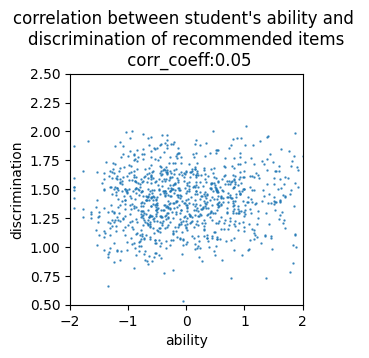

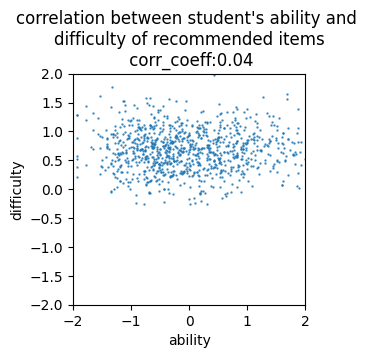

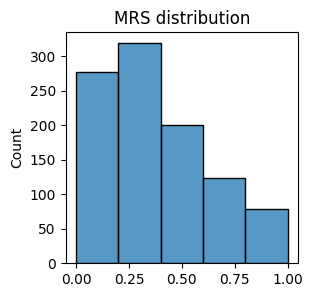

RMSET 0.11575


In [41]:

############################ random
recommend_items_list = []
diff_list = []
disc_list = []
mrs_list = []

for user in target_user[:n_test]:
  # user = '458_50950208'
  df_user = df[df.uid==user].sort_values('est_challenging')
  #display(df_user)
  ##########################################
  df_user = df[df.uid==user]
  recommend_items = random.sample(set(df_user.iid), min(nb_recommend_items, len(df_user)))
  recommend_items_list.append(recommend_items)
  ##########################################
  diff_list.append(irt[irt.Item_ID.isin(recommend_items)].diffi.mean())
  disc_list.append(irt[irt.Item_ID.isin(recommend_items)].disc.mean())
  mrs = df_user.r_ui[:nb_recommend_items].mean()-1
  mrs_list.append(mrs)
  #print('for user', user, 'recommend', recommend_items.tolist(), '________ Real score was', mrs)

corr_ability()
MRSplot()
RMSET()

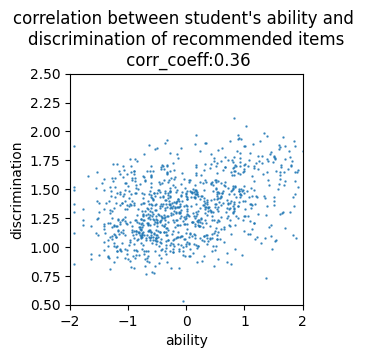

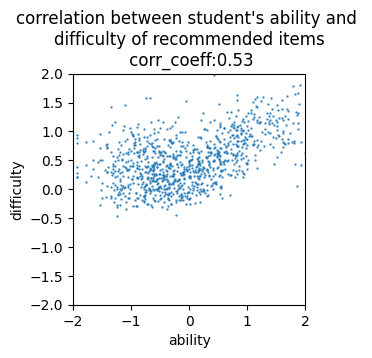

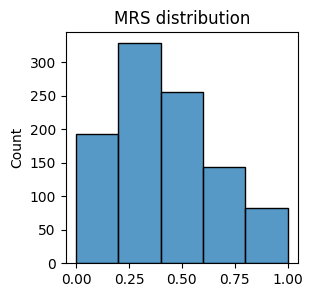

RMSET 0.097


In [42]:
############################threshold에 가까운 문항
recommend_items_list = []
diff_list = []
disc_list = []
mrs_list = []
for user in target_user[:n_test]:
  # user = '458_50950208'
  df_user = df[df.uid==user].sort_values('est_challenging')
  #display(df_user)
  ##########################################
  recommend_items = df_user.iid[:nb_recommend_items]
  recommend_items_list.append(recommend_items)
  ##########################################
  diff_list.append(irt[irt.Item_ID.isin(recommend_items)].diffi.mean())
  disc_list.append(irt[irt.Item_ID.isin(recommend_items)].disc.mean())
  mrs = df_user.r_ui[:nb_recommend_items].mean()-1
  mrs_list.append(mrs)
  #print('for user', user, 'recommend', recommend_items.tolist(), '________ Real score was', mrs)

corr_ability()
MRSplot()
RMSET()

## Tensor Factorization 사용 : U_R, U_S, U_F 모두 사용하기 위함
Yong-Deok Kim and Seungjin Choi, “Non-negative tucker decomposition”, IEEE Conference on Computer Vision and Pattern Recognition s(CVPR), pp 1-8, 2007


In [43]:
# 행렬분해 >>>> 텐서분해로 일반화
!pip install -U tensorly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
# 샘플 예제
import tensorly as tl
import numpy as np
from tensorly import random
from tensorly.decomposition import tucker

tensor = tl.tensor(np.arange(24).reshape((3, 2, 4)), dtype=tl.float64)
print('---------------------------임의의 텐서')
print(tensor)

unfolded = tl.unfold(tensor, mode=0)
tl.fold(unfolded, mode=0, shape=tensor.shape)
tl.set_backend('numpy') # Or 'mxnet', 'numpy', 'tensorflow', 'cupy' or 'jax'

# Apply Tucker decomposition
tucker_tensor = tucker(tensor, rank = 2)
# Reconstruct the full tensor from the decomposed form
print("---------------------------Reconstructed된 텐서")
tl.tucker_to_tensor(tucker_tensor)

---------------------------임의의 텐서
[[[ 0.  1.  2.  3.]
  [ 4.  5.  6.  7.]]

 [[ 8.  9. 10. 11.]
  [12. 13. 14. 15.]]

 [[16. 17. 18. 19.]
  [20. 21. 22. 23.]]]
---------------------------Reconstructed된 텐서


/usr/local/lib/python3.9/dist-packages/tensorly/tucker_tensor.py:425: RuntimeWarning: Given only one int for 'rank' for decomposition a tensor of order 3. Using this rank for all modes.
  warnings.warn(message, RuntimeWarning)


array([[[6.37464101e-16, 1.00000000e+00, 2.00000000e+00, 3.00000000e+00],
        [4.00000000e+00, 5.00000000e+00, 6.00000000e+00, 7.00000000e+00]],

       [[8.00000000e+00, 9.00000000e+00, 1.00000000e+01, 1.10000000e+01],
        [1.20000000e+01, 1.30000000e+01, 1.40000000e+01, 1.50000000e+01]],

       [[1.60000000e+01, 1.70000000e+01, 1.80000000e+01, 1.90000000e+01],
        [2.00000000e+01, 2.10000000e+01, 2.20000000e+01, 2.30000000e+01]]])

In [45]:
import tensorly as tl
import numpy as np
from tensorly import random
from tensorly.decomposition import tucker

tensor = tl.tensor([[[1,1,1, 2],
                              [1,2,0,0],
                              [1,1,2, 2],
                              [1,2,1,2]],
                    
                            [[23,20, 40, 50],
                             [33,10, 0, 80],
                             [23,20, 40, 0],
                             [33,10, 40, 80]],
                                                
                            [[1,2,3, 4],
                             [1,1,3, 3],
                             [1,2,3, 4],
                             [1,1,3, 3]]])

print(tensor)

unfolded = tl.unfold(tensor, mode=0)
tl.fold(unfolded, mode=0, shape=tensor.shape)
tl.set_backend('numpy') # Or 'mxnet', 'numpy', 'tensorflow', 'cupy' or 'jax'

# Apply Tucker decomposition
tucker_tensor = tucker(tensor, rank=3)
# Reconstruct the full tensor from the decomposed form
tl.tucker_to_tensor(tucker_tensor)

[[[ 1  1  1  2]
  [ 1  2  0  0]
  [ 1  1  2  2]
  [ 1  2  1  2]]

 [[23 20 40 50]
  [33 10  0 80]
  [23 20 40  0]
  [33 10 40 80]]

 [[ 1  2  3  4]
  [ 1  1  3  3]
  [ 1  2  3  4]
  [ 1  1  3  3]]]


array([[[ 1.37506319e+00,  8.44152046e-01,  1.30818556e+00,
          1.92713906e+00],
        [ 1.58494836e+00,  1.25231805e+00,  1.12878720e-01,
         -1.47430973e-01],
        [ 1.11966117e+00,  7.23279814e-01,  1.93288857e+00,
          1.96155103e+00],
        [ 1.60175913e+00,  9.87885413e-01,  9.39064761e-01,
          1.83206075e+00]],

       [[ 2.63034280e+01,  1.57662181e+01,  4.05522687e+01,
          4.91669255e+01],
        [ 3.31611878e+01,  9.79418527e+00,  2.68936994e-02,
          7.99594046e+01],
        [ 2.17198739e+01,  2.16435926e+01,  3.97857823e+01,
          3.23034044e-01],
        [ 3.07204546e+01,  1.29239430e+01,  3.96187365e+01,
          8.05750348e+01]],

       [[ 1.50387965e+00,  8.79799333e-01,  3.02285742e+00,
          3.39138384e+00],
        [ 1.18682836e+00,  7.29005577e-01,  3.02807164e+00,
          2.92522181e+00],
        [ 1.84859603e+00,  1.05177848e+00,  3.16587785e+00,
          3.95580416e+00],
        [ 1.37021037e+00,  8.20494941e-

In [46]:
import torch
tensor_r = np.array(U_R.fillna(0))
tensor_s = np.array(U_S.fillna(0))
tensor_f = np.array(U_F.fillna(0))

tensor = torch.tensor(np.array([tensor_r, tensor_s, tensor_f]))
tensor = torch.round(tensor).int()
print(tensor.shape)
print(tensor)

# #unfolded = tl.unfold(tensor, mode='invalid_mode')
# tl.fold(unfolded, mode=0, shape=tensor.shape)
# tl.set_backend('numpy') # Or 'mxnet', 'numpy', 'tensorflow', 'cupy' or 'jax'

# # Apply Tucker decomposition
# tucker_tensor = tucker(tensor, rank=3)
# # Reconstruct the full tensor from the decomposed form
# tl.tucker_to_tensor(tucker_tensor)
#########?############

torch.Size([3, 8077, 28])
tensor([[[  2,   1,   2,  ...,   1,   1,   1],
         [  1,   2,   1,  ...,   1,   1,   1],
         [  2,   2,   2,  ...,   2,   2,   2],
         ...,
         [  2,   1,   2,  ...,   1,   1,   2],
         [  1,   2,   1,  ...,   1,   2,   1],
         [  2,   2,   1,  ...,   2,   2,   2]],

        [[ 76,  36,  34,  ...,  11,   9,  23],
         [  9,   2,   4,  ...,   4,   4,   6],
         [ 57,  70,  49,  ...,  18,  13, 320],
         ...,
         [ 89,  23,  39,  ...,  53,  27,  38],
         [114,  26,  19,  ...,  31, 197,  19],
         [ 37,  59,  55,  ..., 105,  99,  58]],

        [[  3,   3,   2,  ...,   3,   3,   2],
         [  1,   1,   1,  ...,   2,   3,   2],
         [  1,   1,   1,  ...,   1,   1,   2],
         ...,
         [  1,   1,   1,  ...,   1,   1,   2],
         [  1,   1,   1,  ...,   1,   1,   1],
         [  2,   2,   3,  ...,   4,   3,   3]]], dtype=torch.int32)


* sparse tensor을 위한 결측치 마스킹 해야 함